# Fraud detection

## Finding people of interest and indicative language, Part 2

### The Enron Corporation
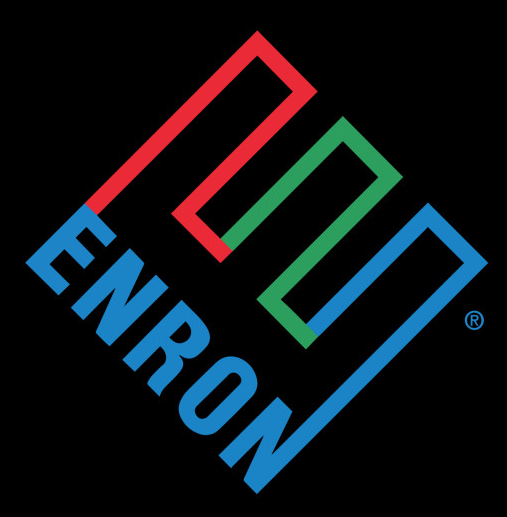

We will start where we left off before and continue exploring the data.  This notebook will also begin some of the prep we will need to get the data ready for modeling

As with any notebook we must begin by importing the libraries we'll need.

In [1]:
import pandas as pd
import numpy as np
import string
from operator import itemgetter
from datetime import datetime
import networkx as nx
import nxviz as nv
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.classify import maxent
import re
import os
from email.parser import Parser
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

C:\Users\penal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


We have a number of variables to load in the notebook so we can pick up right away.  We'll load everything first and then review the headers to make sure everything ported over properly.

In [2]:
%store -r result
result.head()

,from_field,recipient_1,recipient_2,recipient_3,date,subject,body
0,jason.williams@enron.com,thedolan@yahoo.com,None,None,1980-01-01,Re: Bliss,"Andrew -\n\nThanks for your kind words, my fri..."
1,richard.sanders@enron.com,greg.johnston@enron.com,None,None,1980-01-01,Re: Fort James Canada,The litigation against Ft. James has been sett...
2,stacey.white@enron.com,steve.gim@enron.com,,donald.vinson@enron.com,1980-01-01,Dana's VaR,I put together the following spreadsheet for t...
3,kevin.ruscitti@enron.com,jjcardiff@duke-energy.com,None,None,1980-01-01,Re: California Dreamin',"Jeff,\n\nThought you might appreciate this.\n\..."
4,sally.beck@enron.com,greg.piper@enron.com,None,None,1980-01-01,RE: Update on Confirm Logic,I have set aside my afternoon today to complet...


In [3]:
%store -r top_sender
top_sender =list(top_sender)
top_sender

['jeff.dasovich@enron.com',
 'gerald.nemec@enron.com',
 'phillip.love@enron.com',
 'darron.giron@enron.com',
 'dan.hyvl@enron.com',
 'arsystem@mailman.enron.com',
 'john.arnold@enron.com',
 'sally.beck@enron.com',
 'kay.mann@enron.com',
 'carol.clair@enron.com',
 'susan.mara@enron.com',
 'matthew.lenhart@enron.com',
 'j.kaminski@enron.com',
 'john.lavorato@enron.com',
 'mark.haedicke@enron.com',
 'kimberly.watson@enron.com',
 'mike.grigsby@enron.com',
 'sara.shackleton@enron.com',
 'mark.taylor@enron.com',
 'm..presto@enron.com',
 'mike.maggi@enron.com',
 'steven.kean@enron.com',
 'debra.perlingiere@enron.com',
 'bill.williams@enron.com',
 'chris.germany@enron.com',
 'mike.mcconnell@enron.com',
 'david.delainey@enron.com',
 'shelley.corman@enron.com',
 'chris.dorland@enron.com',
 'rod.hayslett@enron.com',
 'enron.announcements@enron.com',
 'drew.fossum@enron.com',
 'tana.jones@enron.com',
 'kate.symes@enron.com',
 'd..steffes@enron.com',
 'vince.kaminski@enron.com',
 'richard.sanders@e

In [4]:
%store -r top_recipient
top_recipient

['<.brandon@enron.com>',
 'vkaminski@aol.com',
 '<.cooper@enron.com>',
 '<.angelica@enron.com>',
 'jeffrey.hodge@enron.com',
 'rick.buy@enron.com',
 '<.taylor@enron.com>',
 'louise.kitchen@enron.com',
 'j.kaminski@enron.com',
 'jeff.skilling@enron.com',
 'chris.germany@enron.com',
 'gerald.nemec@enron.com',
 '<.brad@enron.com>',
 'mike.maggi@enron.com',
 'susan.bailey@enron.com',
 '<.arthur@enron.com>',
 'kate.symes@enron.com',
 '<.byers@enron.com>',
 '<.chris@enron.com>',
 'susan.mara@enron.com',
 'daren.farmer@enron.com',
 'klay@enron.com',
 'benjamin.rogers@enron.com',
 'don.baughman@enron.com',
 '<.bat@enron.com>',
 '<.ward@enron.com>',
 '<.bill@enron.com>',
 'ggreen2@txu.com',
 'john.lavorato@enron.com',
 'mark.taylor@enron.com',
 '<.andre@enron.com>',
 'alan.aronowitz@enron.com',
 'john.arnold@enron.com',
 'rod.hayslett@enron.com',
 'greg.whalley@enron.com',
 '<.palmer@enron.com>',
 'samantha.boyd@enron.com',
 'karen.lambert@enron.com',
 '<.williams@enron.com>',
 '<.brian@enron.c

In [5]:
%store -r df
df.head()

,date_time,body,from_field,to_field,subject,dates,date
0,1980-01-01 00:00:00+00:00,"Andrew -\n\nThanks for your kind words, my fri...",jason.williams@enron.com,thedolan@yahoo.com,Re: Bliss,1980-01-01,1980-01-01
1,1980-01-01 00:00:00+00:00,The litigation against Ft. James has been sett...,richard.sanders@enron.com,greg.johnston@enron.com,Re: Fort James Canada,1980-01-01,1980-01-01
2,1980-01-01 00:00:00+00:00,I put together the following spreadsheet for t...,stacey.white@enron.com,steve.gim@enron.com donald.vinson@enron.com,Dana's VaR,1980-01-01,1980-01-01
3,1980-01-01 00:00:00+00:00,"Jeff,\n\nThought you might appreciate this.\n\...",kevin.ruscitti@enron.com,jjcardiff@duke-energy.com,Re: California Dreamin',1980-01-01,1980-01-01
4,1980-01-01 00:00:00+00:00,I have set aside my afternoon today to complet...,sally.beck@enron.com,greg.piper@enron.com,RE: Update on Confirm Logic,1980-01-01,1980-01-01


Let's look at the summary statistics for the 'from' field and use that person as a test for our process.

In [6]:
result.from_field.describe()

count                      240792
unique                      19647
top       jeff.dasovich@enron.com
freq                         5478
Name: from_field, dtype: object

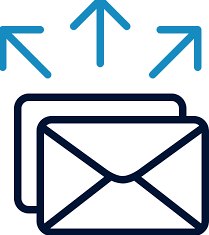

It looks like Kay Mann is the person to look at.  We can pull these emails into a separate dataframe and take a look at the shape and statistics of the individual's email traffic.

In [7]:
km_df = df[df['from_field'] ==('jeff.dasovich@enron.com')]
km_df.describe()

,dates
count,5478
mean,2001-04-08 12:07:47.910916352
min,1980-01-01 00:00:00
25%,2000-12-14 11:25:45
50%,2001-04-10 15:56:00
75%,2001-08-05 22:45:52.500000
max,2002-01-08 17:43:16


In [8]:
km_text=[]
for mail in km_df.body:
    km_text.append(km_df.body.values)

In order to process the text, we need to convery everythign back to a string.  

In [9]:
km_text[10]

array(["Agreed. I'm on vacation this week (in the high sierra's and unreachable by \nany means) and back next monday.  can we try to hook up next monday.  hope \nall goes well in portland.\n\nbest,\nJeff\n\n\n\n\ngramlr@pjm.com on 08/17/2000 05:25:20 AM\nTo: jdasovic@enron.com\ncc:  \nSubject: RE: APPA\n\n\nLet's discuss this soon to at least agree on a set of desirable candidates.\nObviously we won't be able to get invitations and accepted invitations within\nthe next week or two, but we can jointly determine a set of candidates that \nare\nacceptable.  I leave today for Portland so maybe we can talk on Monday.\nRob\n\n> -----Original Message-----\n> From: jdasovic@enron.com [SMTP:jdasovic@enron.com]\n> Sent: Wednesday, August 16, 2000 5:07 PM\n> To: gramlr@pjm.com\n> Subject: RE: APPA\n>\n>\n> Just one thing to keep in mind.  As you can imagine, the agenda and who\n> participates is going to factor into our sponsorship.  Sooner we get the\n> agenda/participants squared away, the bett

In [10]:
len(km_text)

5478

In [11]:
km_email=str(km_text)
type(km_email)

str

Here we will be using a tokenizer from NLTK to process the word frequency.  Hopefully doing this will give us an idea of common email themes from Kay.  

In [12]:
#tokenized object
words= word_tokenize(km_email)

#customizing the stopwords by adding punctuation
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

#removing stop words
useful_words = [word for word in words if word not in stopwords_list]

In [13]:
#using the Frequency distribution method built into NLTK and looking at the 100 most common words
frequency = nltk.FreqDist(useful_words)
 
print(frequency.most_common(100))

[('--', 268422), ('\\n', 230076), ('File', 147906), ('I', 98604), ('Budget', 98604), ("'s", 87648), ('``', 54780), ('-Original', 54780), ('Message', 54780), ("''", 54780), ('Jeff', 49302), ('\\nSent', 43824), ('2002', 43824), ('\\n\\n', 38346), ('I\\', 38346), ('PM\\nTo', 38346), ('-\\nFrom', 38346), ('January', 38346), ('jdasovic', 32868), ('2000', 32868), ('contact', 32868), ('S/Enron', 32868), ('issues', 32868), ('\\tKaufman', 32868), ('\\tWednesday', 32868), ('02', 32868), ('\\tDasovich', 32868), ("'m", 27390), ('\\nSubject', 27390), ('get', 27390), ('enron.com', 27390), ('To', 27390), ('gramlr', 27390), ('Subject', 27390), ('clear', 27390), ('work', 27390), ('capacity', 27390), ('California', 27390), ('UDCs', 27390), ('Paul', 27390), ('budget', 27390), ('\\tRE', 27390), ('1999', 27390), ('AM\\nTo', 21912), ('APPA\\n', 21912), ('time', 21912), ("'d", 21912), ('like', 21912), ('provide', 21912), ('ENRON', 21912), ('Pedersen', 21912), ("'ve", 21912), ('put', 21912), ('North', 21912),

Awesome.  There are some odd things in here, but that's fine.  I think it would be great to see what this looks like on the whole data set.  We'll time this one because this is a process heavy step.  We'll also add some intermediary checks to ensure that we knwo the code is still running.

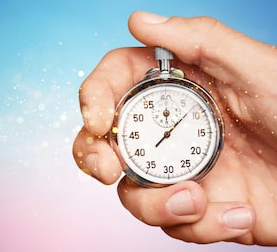

In [14]:
start = datetime.now()

text=[]
for mail in df.body:
    text.append(df.body.values)
print("checking the length\n", len(text))

email=str(text)

print("\nchecking the type\n", type(email))

words_all= word_tokenize(email)

useful_words_all = [word for word in words_all if word not in stopwords_list]
frequency_all = nltk.FreqDist(useful_words_all)
 
print("\n\n\nThe Total email 100 most common words are: \n\n",frequency_all.most_common(100))

finish = datetime.now()
elapsed = finish-start
print("\n\n{} has elapsed.".format(elapsed))

checking the length
 240792

checking the type
 <class 'str'>



The Total email 100 most common words are: 

 [('--', 12521184), ('I', 3371088), ('James', 2167128), ('Fort', 2167128), ('Enron', 1444752), ('Canada', 1203960), ('day', 963168), ('In', 963168), ('gas', 963168), ('Kurt', 963168), ('Anderson/EWC/Enron', 963168), ('availability', 963168), ('friend', 722376), ('say', 722376), ('peace', 722376), ('\\n\\nSubject', 722376), ('year', 722376), ('``', 722376), ('The', 722376), ('litigation', 722376), ('transact', 722376), ('Corp.', 722376), ('following', 722376), ("''", 722376), ('Dec', 722376), ('grid', 722376), ('data', 722376), ('words', 481584), ('Your', 481584), ('would', 481584), ('PM\\nTo', 481584), ('wanted', 481584), ('I\\nam', 481584), ('work', 481584), ('every', 481584), ('happy', 481584), ('hope', 481584), ('agreed', 481584), ('\\nto', 481584), ('master', 481584), ('left', 481584), ('To', 481584), ('B', 481584), ('ECT\\n\\t\\t', 481584), ('Cyntia', 481584), ('may', 4815

Because of the way we parsed the emails in part one we have some characters and weird things that we need to get rid of.  We can also get rid of thinks that are related to phone numbers in people's signature blocks, such as '+44'.  That's the country code for the U.K.  I don't think that alone will help us detect fraud.  

We'll accomplish most of this by just adding to a list, then removing those again by substituting them with nothing.   

In [15]:
subs = ["\\n", "--","I","''","Messege","\\t","-Added","-Original","-Deleted","To","1","No","''","``",
        "From","...","Cc","``","'s","''","\\","``","+44","207","484","'", "5546","09","2001","53", "\\n\\nSubject",
        "PM\\nTo", "AM\\nTo"]
start = datetime.now()
for char in subs:
    email = email.replace(char, "")

finish = datetime.now()
elapsed = finish-start
print("\n\n{} has elapsed.".format(elapsed))



0:00:37.553040 has elapsed.


Now that has been done we can run the code again, those time we can just use our timer since we're sure the code will run.

In [16]:
start = datetime.now()


words_all= word_tokenize(email)


useful_words_all = [word for word in words_all if word not in stopwords_list]
frequency_all = nltk.FreqDist(useful_words_all)
 
print("\n\n\nThe Total email 100 most common words are: \n\n",frequency_all.most_common(100))

finish = datetime.now()
elapsed = finish-start
print("\n\n{} has elapsed.".format(elapsed))




The Total email 100 most common words are: 

 [('James', 2648712), ('Fort', 2167128), ('Enron', 1444752), ('Canada', 1444752), ('200', 1203960), ('day', 963168), ('PM', 963168), ('Subject', 963168), ('n', 963168), ('gas', 963168), ('Kurt', 963168), ('Anderson/EWC/Enron', 963168), ('availability', 963168), ('friend', 722376), ('say', 722376), ('peace', 722376), ('year', 722376), ('``', 722376), ('The', 722376), ('litigation', 722376), ('AM', 722376), ('transact', 722376), ('ECC', 722376), ('Corp.', 722376), ('following', 722376), ("''", 722376), ('spreadsheet', 722376), ('Dec', 722376), ('grid', 722376), ('data', 722376), ('words', 481584), ('Your', 481584), ('would', 481584), ('wanted', 481584), ('work', 481584), ('every', 481584), ('time', 481584), ('happy', 481584), ('hope', 481584), ('agreed', 481584), ('master', 481584), ('left', 481584), ('B', 481584), ('ECT', 481584), ('Cyntia', 481584), ('may', 481584), ('continuing', 481584), ('relating', 481584), ('us', 481584), ('However',

Awesome!  This is much better looking.  In here you can already see a few things that might have indicated that something was off.  There are a lot of last names in here as well as words like 'issues' and 'pressue'.  

Let's make these top words a dictionary so we can easily plot their frequency.

In [17]:
top_words = frequency_all.most_common(100)
top_words = dict(top_words)

In [18]:
#data check
len(top_words)

100

In [19]:
x=list(top_words.keys())
y=list(top_words.values())

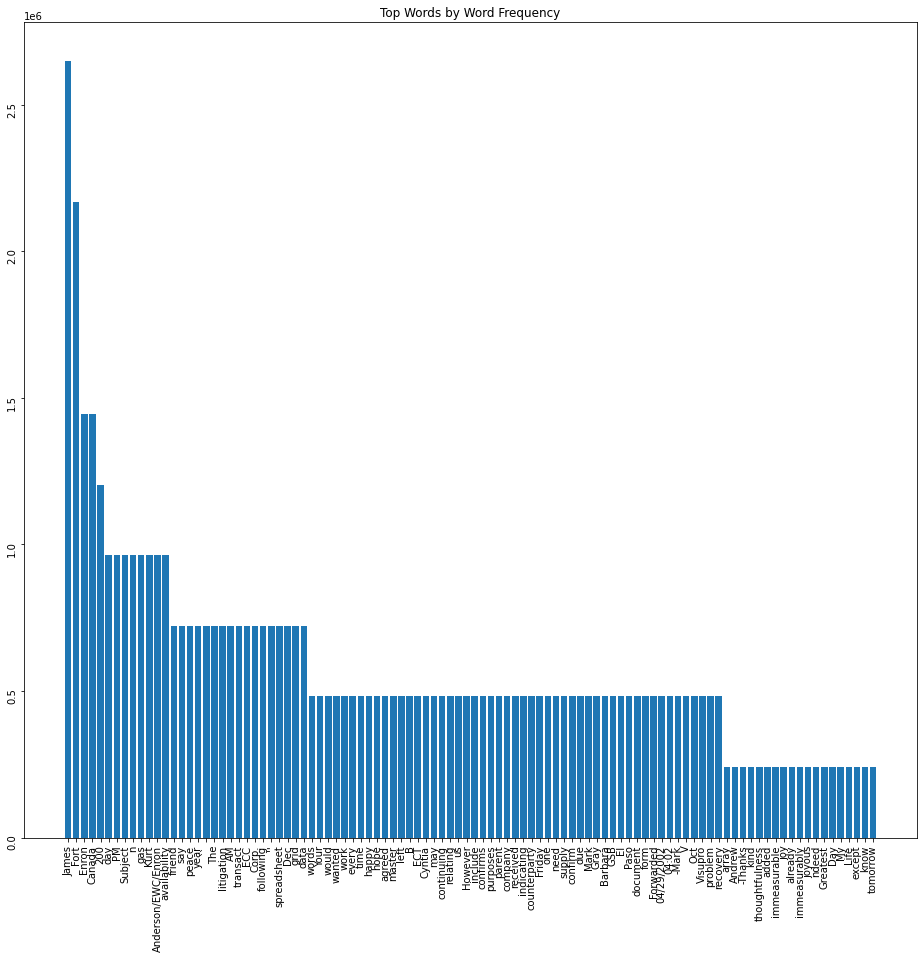

In [20]:
#plotting a bar graph of the top words
plt.figure(figsize = (16,15))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.yticks(rotation=90)
plt.title("Top Words by Word Frequency")
plt.show()

In my opinion this is a great way to look at the data and it makes it very easy to see if something sticks out.  An even better visualization is a word cloud.  The python library 'wordcloud' makes this very easy.

In [21]:
#converting the useful words back to a string
comment_words = str(useful_words_all)

In [22]:
#initializing the wordcloud object
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords_list, 
                min_font_size = 10).generate(comment_words)

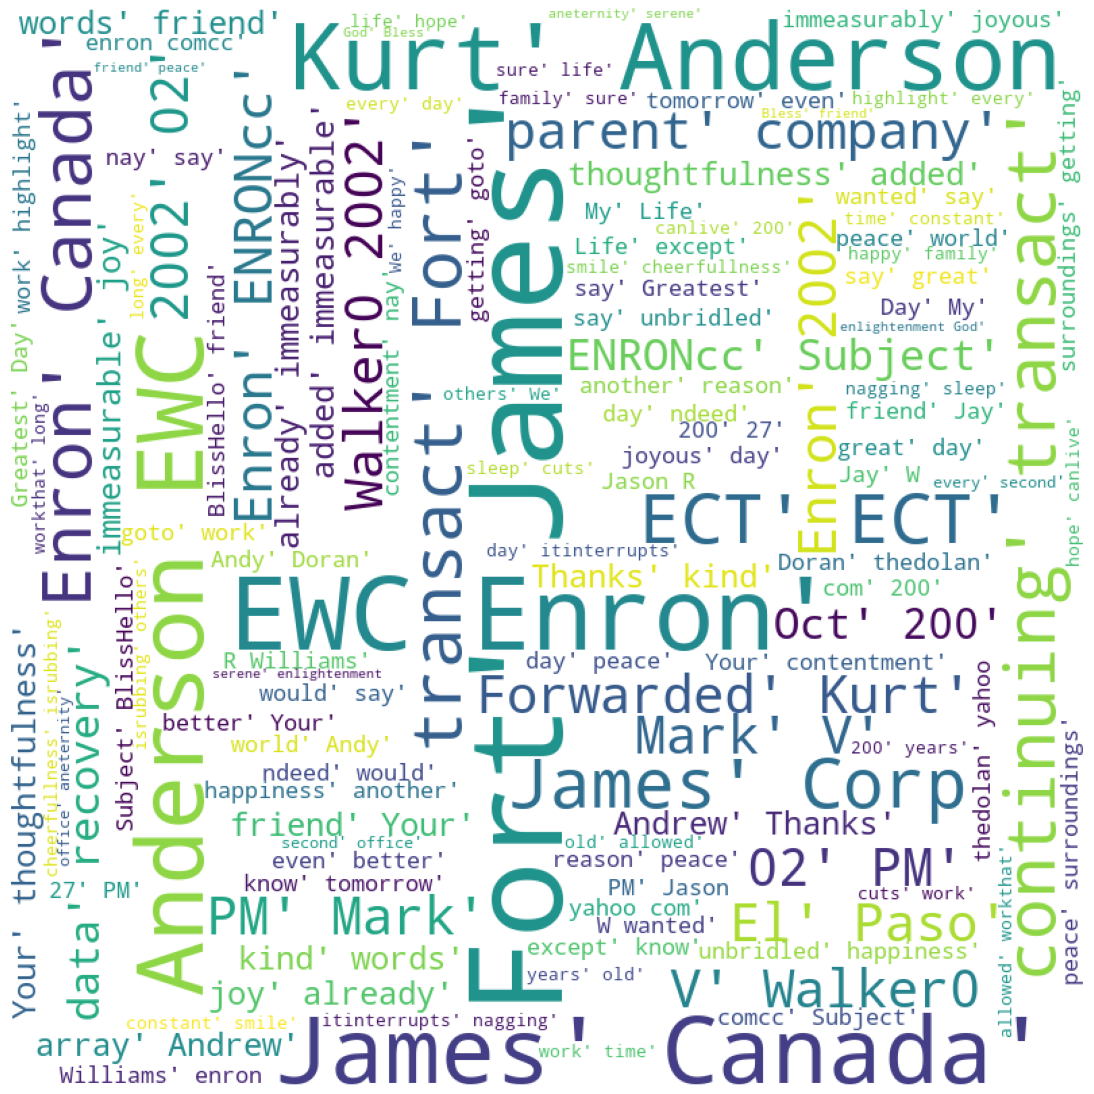

In [23]:
# plotting the WordCloud image using matplot                        
plt.figure(figsize = (15,15), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

Fuel, Oil, and Flow all make sense.  However, if you loop here there are some changes we can make to get. abetter image.  We'll make everything lower case in our dictionary then replot the wordcloud.


In [24]:
top_keys =list(top_words.keys())
most_frequent={}
for key in top_keys:
    new = key.lower()
    most_frequent[new]=top_words[key]

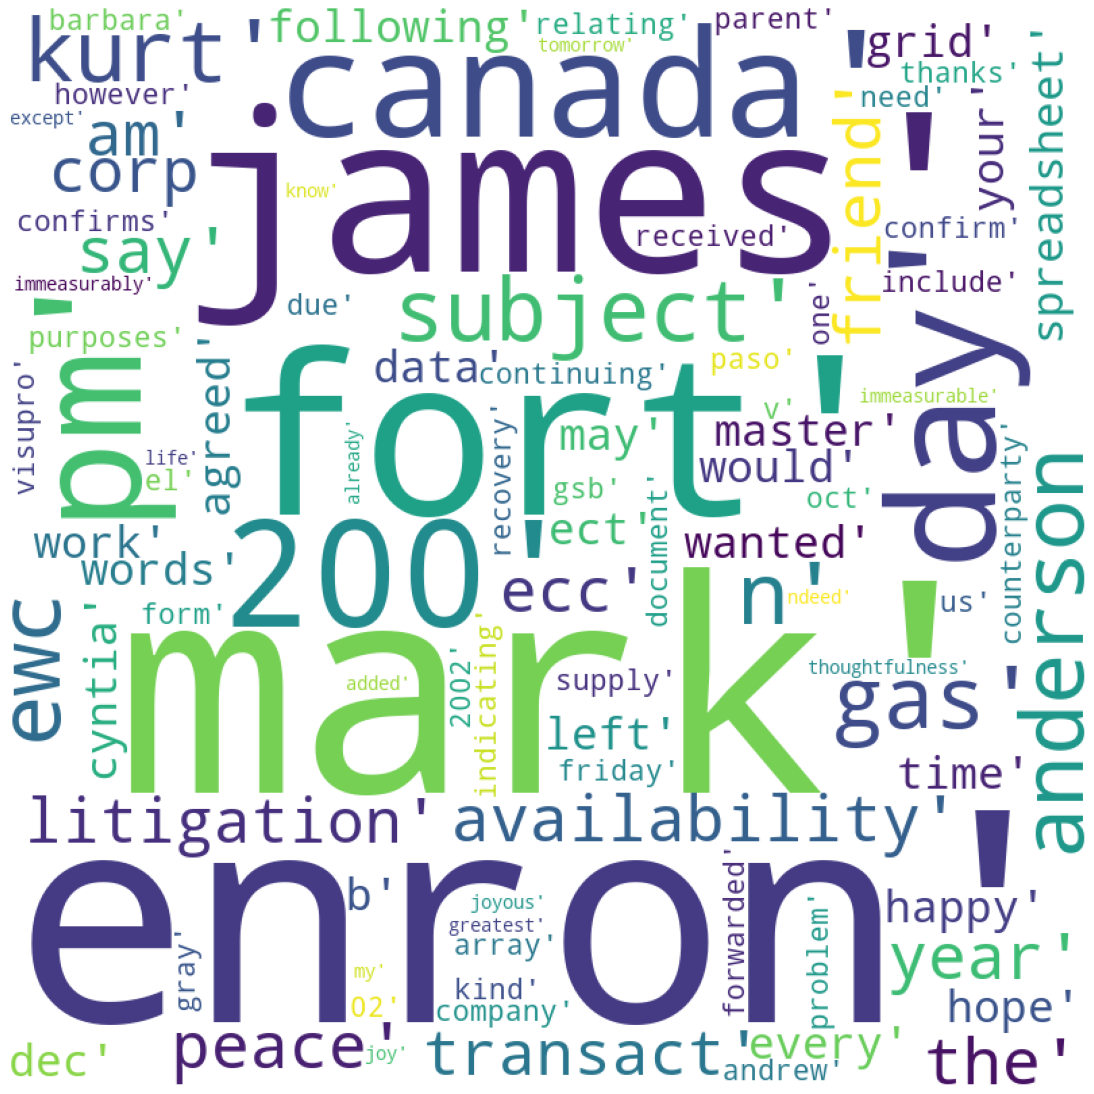

In [25]:
#creating WordCloud object
comment_words2 = str(most_frequent)
wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords_list, 
                min_font_size = 10).generate(comment_words2)

# plot the WordCloud image                        
plt.figure(figsize = (15,15), facecolor = None) 
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

Great! It looks like we have a lot of people's names floating in there and we have a number of possible red-flag words.  

Todd Cimino was one of the Enron employees who ended up testifying agaisnt Skilling.  It makes sense that he would be relatively high on the list.  In August the US goverment seized over $200k from Kathy Lynn's personal bank accounts due to llegal transactions orchestrateded by  executives Michael Kopper and Andrew Fastow.  So again seeing 'Kathy' often also makes sense.  


We're going to move to our third notebook so before we do, we can save all the variables we might need going forward.

In [26]:
%store km_text
%store useful_words
%store frequency

Stored 'km_text' (list)
Stored 'useful_words' (list)
Stored 'frequency' (FreqDist)


In [27]:
%store top_words
%store most_frequent

Stored 'top_words' (dict)
Stored 'most_frequent' (dict)


### If you'd like to continue please move on to notebook, part 3.